In [1]:
import sys
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

## imports

In [166]:
import os
import torch
import pickle
import numpy as np
import pandas as pd
from functools import partial
from itertools import product
from tqdm.autonotebook import tqdm

In [4]:
from chequeparser.wrappers.detection_results import DetectionResults
from chequeparser.wrappers.bbox import BBox
from chequeparser.utilities.ds_utils import concat_ds

In [5]:
from chequeparser.datasets.fileds import FileDS
from chequeparser.datasets.imageds import ImageDS
from chequeparser.datasets.base import BaseDS

In [6]:
from chequeparser.models.arch import UL_RTDETR, DOCTR_RECOG_PRETRAINED, DOCTR_DETECT_PRETRAINED
from chequeparser.models.detection.ultralytics import UltralyticsDetect
from chequeparser.models.detection.doctr import DoctrDetect
from chequeparser.models.recognition.doctr import DoctrRecognize
from chequeparser.models.detection.gcv import GCVDetect
from chequeparser.core.detector import detect
from chequeparser.core.recognizer import recognize
from chequeparser.utilities.io_utils import save_dets, load_dets
from chequeparser.utilities.misc import get_samples
from chequeparser.datasets.loaders import load_yolo

In [7]:
import pkg_resources
from symspellpy import SymSpell

In [170]:
from pytorch_widedeep import Trainer
from pytorch_widedeep.models import TabMlp, WideDeep, BasicRNN

## configs

In [8]:
dir_images = "../data/public/images/"

In [9]:
dir_sav = "temp/"

In [10]:
f_roi_model = "../pretrained/best.pt"
f_dets_model = "db_resnet50"
f_recs_model = "crnn_vgg16_bn"

In [160]:
f_wd_tab_preproc_model = "temp/tab_preproc.pkl"
f_wd_text_preproc_model = "temp/text_preproc.pkl"
f_wd_model = "temp/model_saved.pt"

## load ds

In [11]:
all_ds = FileDS(dir_images)

  0%|          | 0/235 [00:00<?, ?it/s]

2024-02-21 12:13:09.005 | INFO     | chequeparser.utilities.io_utils:get_files:36 - Found 235 files.


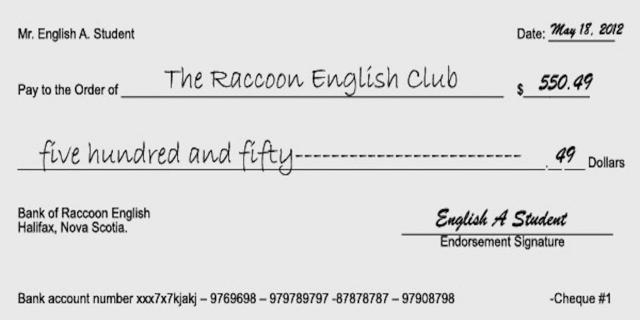

In [195]:
single_ds = all_ds.get_as_ds(170)
single_ds[0]

## load models

In [196]:
roi_model = UltralyticsDetect(UL_RTDETR, f_roi_model)

In [16]:
doctr_det_arch_config = {
    "preserve_aspect_ratio": True,
    "symmetric_pad": True
}
words_model = DoctrDetect(path=f_dets_model, 
                          arch=DOCTR_DETECT_PRETRAINED, 
                          arch_config = doctr_det_arch_config)

In [17]:
rec_model = DoctrRecognize(DOCTR_RECOG_PRETRAINED, f_recs_model)

In [18]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
spell_checker = partial(sym_spell.lookup_compound,
                        max_edit_distance=2, 
                        transfer_casing=True,
                        split_by_space=True,
                        ignore_non_words=True,
                        ignore_term_with_digits=True
                       )
op_spell_check = lambda x: spell_checker(x)[0].term

### wd preprocessors models

In [163]:
with open(f_wd_tab_preproc_model, "rb") as tp:
    tab_preprocessor_new = pickle.load(tp)

In [164]:
with open(f_wd_text_preproc_model, "rb") as tp:
    text_preprocessor_new = pickle.load(tp)

In [178]:
wd_model = torch.load(f_wd_model)

In [180]:
trainer = Trainer(wd_model, objective="binary")

## run models

In [197]:
l_roi_dets = []
for res in tqdm(detect(roi_model, single_ds, stream=True,
                       verbose=False),
              total=len(single_ds)):
    l_roi_dets.append(res)

  0%|          | 0/1 [00:00<?, ?it/s]

In [198]:
l_words_dets = []
for res in tqdm(detect(words_model, single_ds, stream=True),
              total=len(single_ds)):
    l_words_dets.append(res)

2024-02-21 18:26:22.463 | INFO     | chequeparser.core.detector:detect:35 - Stream mode: True
2024-02-21 18:26:22.464 | INFO     | chequeparser.core.detector:detect:36 - Batched mode: False
2024-02-21 18:26:22.465 | INFO     | chequeparser.core.detector:detect:37 - Running predict on 1 samples


  0%|          | 0/1 [00:00<?, ?it/s]

In [199]:
for words_dets in tqdm(l_words_dets):
    temp_ds = words_dets.create_ds(single_ds)
    temp_ds.batched = True
    l_recs = recognize(rec_model, temp_ds, stream=False, verbose=False)
    _ = [box.set_text_and_confidence(rec_results)
     for box, rec_results in zip(words_dets.bboxes, l_recs)]

  0%|          | 0/1 [00:00<?, ?it/s]

## extract features

In [200]:
l_final_anchor_dets = [None]*len(l_roi_dets)

### best anchor roi, based on scores

In [201]:
l_anchor_roi_dets = [roi_dets.filter_by_labels(["orderof"], split=False)
                     for roi_dets in l_roi_dets]

In [202]:
l_left_half_anchor_rois = [anchor_roi_dets.filter_by_region(0, 0.1, 0.35, 0.9)
                           for anchor_roi_dets in l_anchor_roi_dets]
l_left_half_words_dets = [words_dets.filter_by_region(0, 0.1, 0.35, 0.9)
                           for words_dets in l_words_dets]

In [203]:
l_words_inside_rois = [[
                        l_h_w_dets.filter_by_bbox(bbox, thresh=0.7)
                        for bbox in l_h_a_rois.bboxes]
                       for l_h_w_dets, l_h_a_rois in zip(l_left_half_words_dets,
                                                         l_left_half_anchor_rois)
                      ]

In [204]:
l_anchor_scores = [[sum([1 if keyword in bbox.text.lower() else 0 
                      for keyword in ["pay", "to", "the", "order", "of"]
                      for bbox in dets.bboxes])
                 for dets in words_inside_rois]
                for words_inside_rois in l_words_inside_rois]

In [205]:
l_selected_anchor_ids = [max(range(len(anchor_scores)), 
                             key=lambda x : anchor_scores[x])
                         if len(anchor_scores) > 0 else None
                         for anchor_scores in l_anchor_scores]


In [206]:
l_selected_anchor_rois_and_scores = [(rois.filter_by_idxs([idx]), scores[idx])
                          if idx is not None else (rois.new(), -1)
                          for idx, rois, scores in zip(l_selected_anchor_ids, 
                                                       l_left_half_anchor_rois,
                                                       l_anchor_scores)]

In [207]:
for idx in range(len(l_selected_anchor_rois_and_scores)):
    if l_selected_anchor_rois_and_scores[idx][1] > 0:
        l_final_anchor_dets[idx] = l_selected_anchor_rois_and_scores[idx][0]

### backup anchor rois based on word det bboxes

In [208]:
l_spell_corr_left_half_words_dets = [
    left_half_words_dets.new() for left_half_words_dets
    in l_left_half_words_dets]

In [209]:
for lh_dets, spell_dets in zip(l_left_half_words_dets,
                               l_spell_corr_left_half_words_dets):
    spell_dets.bboxes = [
        box.apply_text_op(op_spell_check, lowercase=True)
        for box in lh_dets.bboxes
    ]

In [210]:
l_bkp_anchor_dets = [
    dets.filter_by_bbox_text("order").filter_by_idxs([0])
    for dets in l_spell_corr_left_half_words_dets]

In [211]:
l_bkp2_anchor_dets = [
    dets.filter_by_bbox_text("pay", True).filter_by_idxs([0])
    for dets in l_spell_corr_left_half_words_dets]

In [212]:
l_final_anchor_dets[0].bboxes[0].normalize(single_ds[0].width, single_ds[0].height)

{'x1': 0.0171875, 'y1': 0.2375, 'x2': 0.1921875, 'y2': 0.3125, 'normalized': True, 'conf': 0.8759539723396301, 'label': 'orderof', 'text': '', 'text_conf': 0}

In [213]:
l_dummy_anchor_dets = [
    dets.new([BBox(0.03, 0.33, 0.11, 0.41, normalized=True)])
    for dets in l_spell_corr_left_half_words_dets
]

In [214]:
def pick_non_empty(*iterables):
    final = []
    for items in zip(*iterables):
        for item in items:
            if item is not None and len(item) > 0:
                final.append(item)
                break
        else: final.append(None)
    return final

In [215]:
l_feature_anchor_dets = pick_non_empty(l_final_anchor_dets, l_bkp_anchor_dets, l_bkp2_anchor_dets,
                     l_dummy_anchor_dets)

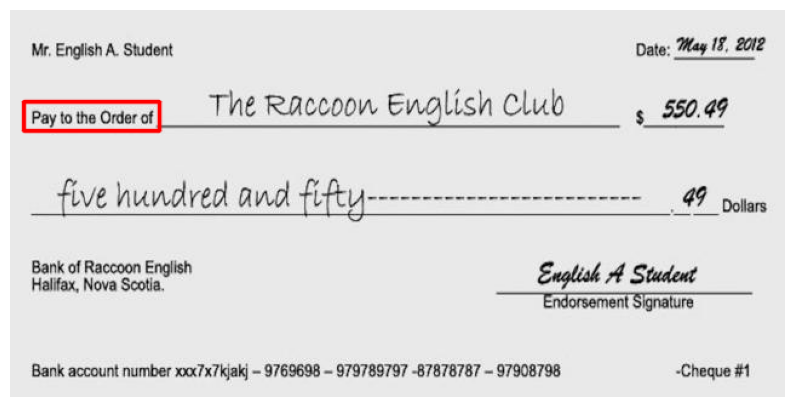

In [217]:
l_feature_anchor_dets[0].draw(single_ds)

### extract list of payees

In [218]:
l_payee_roi_dets = [roi_dets.filter_by_labels(["payee"], split=False)
                     for roi_dets in l_roi_dets]

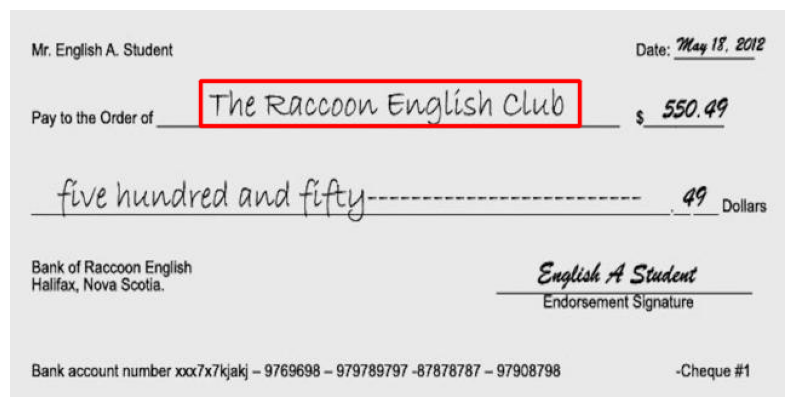

In [220]:
l_payee_roi_dets[0].draw(single_ds)

In [222]:
l_eligible_payee_rois = [payee_roi_dets.filter_by_conf(0.6)
                         for payee_roi_dets in l_payee_roi_dets]

In [223]:
l_high_conf_payee_rois = [payee_roi_dets.filter_by_conf(0.89).filter_by_labels(labels=["payee"],
                                                                              only_max_conf=True,
                                                                              split=False)
                         for payee_roi_dets in l_payee_roi_dets]

In [224]:
l_words_inside_h_c_p_rois = [
    words_dets.filter_by_bbox(dets.bboxes[0]).sort_bboxes_lr().group_bboxes() if len(dets) > 0
    else words_dets.empty()
    for words_dets, dets in zip(l_words_dets, l_high_conf_payee_rois)
]

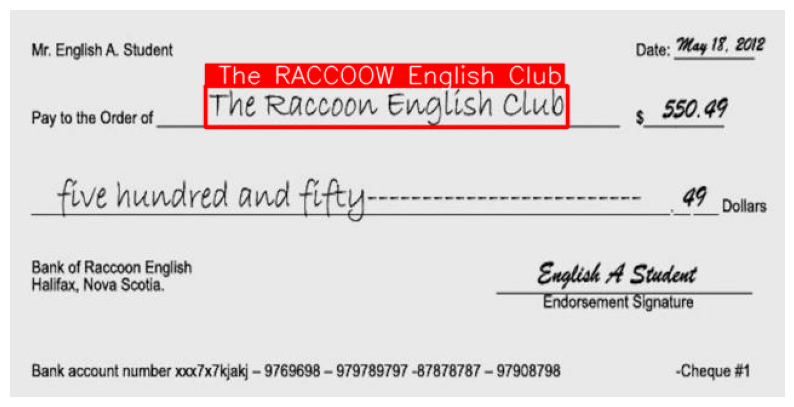

In [225]:
l_words_inside_h_c_p_rois[0].draw(single_ds, show_text=True)

In [143]:
l_left_half_words_dets = [words_dets.filter_by_region(0, 0.2, 0.6, 0.9)
                           for words_dets in l_words_dets]

In [148]:
l_l_h_lines_dets = [
    words_dets.sort_bboxes_lr().group_bboxes(detect_lines=True)
    if len(dets) > 0 else words_dets.empty()
    for words_dets, dets in zip(l_left_half_words_dets, l_high_conf_payee_rois)
]

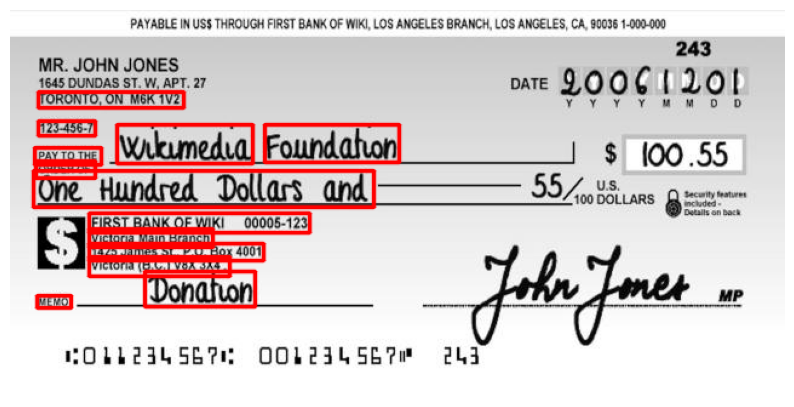

In [149]:
l_l_h_lines_dets[0].draw(single_ds)

### create df

In [153]:
def merge_(anchor_, payee_):
    anchor_ = anchor_.astype(np.float32)
    payee_box_ = payee_[:4].astype(np.float32)
    payee_text_ = payee_[-1]
    return anchor_.tolist() + payee_box_.tolist() + [payee_text_]

In [154]:
l_rows = []

for anchor, payee in zip(l_feature_anchor_dets,
                           l_l_h_lines_dets):
    payee_data = payee.to_numpy(encode=False, normalize=True)[:, [0, 1, 2, 3, -2]]
    anchor_data = anchor.to_numpy(encode=False, normalize=True)[:, :4]
    products = list(merge_(x, y) for x, y in product(anchor_data, payee_data))
    l_rows += products

In [157]:
data_df = pd.DataFrame(l_rows, columns=["anchor_x1", "anchor_y1", "anchor_x2", "anchor_y2",
                                             "payee_x1", "payee_y1", "payee_x2", "payee_y2",
                                             "payee_txt"])

In [158]:
data_df.head()

,anchor_x1,anchor_y1,anchor_x2,anchor_y2,payee_x1,payee_y1,payee_x2,payee_y2,payee_txt
0,0.028125,0.346875,0.117188,0.43125,0.035937,0.212500,0.223438,0.253125,"TORONTO, ON M6K 1V2"
1,0.028125,0.346875,0.117188,0.43125,0.035937,0.287500,0.109375,0.325000,123-456-7
2,0.028125,0.346875,0.117188,0.43125,0.137500,0.296875,0.312500,0.396875,Wikumedia
3,0.028125,0.346875,0.117188,0.43125,0.031250,0.356250,0.117188,0.400000,PAYTOTHE
4,0.028125,0.346875,0.117188,0.43125,0.328125,0.296875,0.501562,0.393750,Foundahon


### run classifier

In [185]:
X_tab_te = tab_preprocessor_new.transform(data_df)
X_text_te = text_preprocessor_new.transform(data_df)
preds = trainer.predict_proba(X_tab=X_tab_te, X_text=X_text_te, batch_size=32)

predict: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


In [191]:
best_pred_id = np.argmax(preds[...,1])

In [193]:
data_df.iloc[best_pred_id]["payee_txt"]

'Wikumedia'